# グラフ埋め込み

In [1]:
import numpy as np
import networkx as nx

%matplotlib inline

In [2]:
DRAW_CONFIG = {
    'node_color': 'white',
    'edgecolors': 'black', # line color of nodes
    'with_labels': True,
    'node_size': 600,
    'font_size': 14,
    'font_family': 'Arial',
}

In [3]:
try:
    import torch_geometric
except:
    !pip install torch_geometric

---

## クイズ

### Q1: ランダムウォーク

以下のグラフ$G_{maze}$において，任意のノードからスタートし，ランダムウォークを$L$回したときの経路を得る関数`get_random_walk_path`を定義しなさい．
関数`get_random_walk_path`の引数はグラフ`G`，出発ノード`node_from`，経路の長さ（ランダムウォークの回数）`length`とし，返り値は`[0, 4, ..., 3]`のようなノードのリストとすること．
なお，このクイズではNetworkxの`generate_random_paths`関数は用いないこと．

※ ヒント: あるノードに隣接するノードのリストを得るには，Networkxのグラフオブジェクトの`neighbors`メソッドを用いればよい．
またリストからランダムに要素を取得するには`random`パッケージの`choice`メソッドを用いればよい．

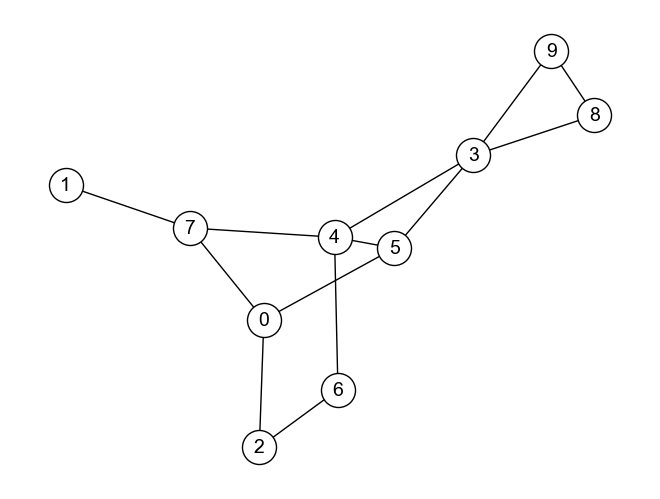

In [4]:
G_maze = nx.sedgewick_maze_graph()
G_maze.add_edges_from([(3, 8), (3, 9), (8, 9)])
pos = nx.spring_layout(G_maze, seed=123)
nx.draw(G_maze, pos, **DRAW_CONFIG)

In [ ]:
# Write your code
def get_random_walk_path(G, node_from, length):
    ''' node_from: グラフG上でランダムウォークを開始するノード
        length: ランダムウォークして得る経路の長さ
    '''


# グラフを定義
G_maze = nx.sedgewick_maze_graph()

# 定義した関数を用いて経路を得る
# get_random_walk_path(G_maze, node_from=1, length=10)

### Q2: node2vecのためのランダムウォーク

クイズQ1で定義した`get_random_walk_path`関数を改良し，node2vecアルゴリズムに従うランダムウォーク経路を生成する関数`get_random_walk_path_for_n2v`を定義しなさい．
なお，関数`get_random_walk_path_for_n2v`の引数として以下を設定しなさい．
- G: グラフ
- node_from: 経路の始点となるノード
- length: 経路の長さ
- p: 再訪性パラメータ（float型）
- q: In-outパラメータ（float型）

※ ヒント: 指定した重み（確率分布）に従ってリストから要素を取得するには，`random`パッケージの`choices`関数を用いる（[参考](https://docs.python.org/ja/3.13/library/random.html#random.choices)）．

In [ ]:
import random

# Write your code
def get_random_walk_path_for_n2v(G, node_from, length, p: float=1, q: float=1):
    ''' node_from: グラフG上でランダムウォークを開始するノード
        length: ランダムウォークして得る経路の長さ
    '''
        

# グラフを定義
#G_maze = nx.sedgewick_maze_graph()

# 定義した関数を用いて経路を得る
#path = get_random_walk_path_for_n2v(G_maze, node_from=1, length=4, p=1, q=0.01)
#path

### Q3: 論文ジャンルの分類（1/2） - 埋め込みベクトルの獲得

[Cora](https://paperswithcode.com/dataset/cora)は論文公開サイト[arXiv](https://arxiv.org)で公開されている機械学習分野の論文の一部を抽出したデータセットである．
データセットには，論文の引用関係（どの論文がどの論文を引用したか）や論文のキーワード情報に加えて，各論文の分野カテゴリを示すラベル情報が含まれている．
分野カテゴリラベルは0から6までの整数値のいずれかをとり，各数値に対応する分野は以下の通りである：

0. Case based
1. Genetic algorithm
2. Neural network
3. Probabilistic method
4. Reinforcement learning
5. Rule learning
6. Theory

分野カテゴリが未知の論文について，そのカテゴリを推定する分類器を機械学習で構築したいとしよう．
第1ステップとして，論文の引用関係から引用関係グラフを構築し，グラフ構造とnode2vecを用いて各論文の埋め込みベクトルを得たい．
以下のPythonコードを追記，修正して，論文の埋め込みベクトルを獲得しなさい．

なお，node2vecのパラメータは以下とする:
- `embedding_dim`: 64
- `walks_per_node`: 10
- `walk_length`: 10
- `context_size`: 5
- `p`および`q`: 任意
- `epoch_num`（学習ループ回数）: 20

In [ ]:
from torch_geometric import datasets
import torch
import torch_geometric
from torch_geometric.nn import Node2Vec

# データの読み込み．以下のコードで読み込めば，PyGライブラリで扱えるグラフデータ形式になっている
paper_dataset = datasets.Planetoid(root="tmp", name="cora", split='full')

# node2vecの設定
model = Node2Vec(
    paper_dataset.edge_index, # 埋め込み対象となるグラフのエッジ情報

    # -------------------------
    # Write your codes below
    # -------------------------
)

# -----------------
# 学習フェーズ
# -----------------
epoch_num = 20

# 微分最適化アルゴリズム
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 学習データの読み込み方法
loader = model.loader(batch_size=32, shuffle=True, num_workers=0)

# 学習
for epoch in range(epoch_num):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw, neg_rw) # 誤差の計算
        loss.backward() # 誤差逆伝播
        optimizer.step() # パラメータ更新
        total_loss += loss.item()
    train_loss = total_loss / len(loader)
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, Train-loss: {train_loss:.4f}')

# -----------
# 埋め込みの取得
# -----------
# モデルを推論モードに切り替え
model.eval() 

# ノード埋め込みベクトル（行列）を得る
X_n2v = model().detach().numpy()

### Q4: 論文ジャンルの分類（2/2） - 分類器の構築

Q3で得たノードの埋め込みベクトルとcoraデータセットの論文カテゴリラベルを用いて，論文のカテゴリを推定する分類器を構築したい．
ベクトルデータを入力とする機械学習手法を用いて分類器を構築し，5分割交差検証を用いて構築した分類器のマクロ適合率，マクロ再現率，マクロF1値を算出しなさい．
なお，用いる機械学習手法は自由とする．

##### ヒント1
マクロ適合率（再現率，F1値）とは，他クラス分類問題の性能評価に用いられる評価基準である．
クラスごとに適合率（再現率，F1値）を計算した後，それらの平均値を取ることで算出する．
Pythonのscikit-learnライブラリを用いれば，以下のように簡単に計算できる．

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_predicted = [0, 1, 2, 0, 0, 0, 2, 1, 1] # 予想されたクラスのリスト
y_test = [0, 1, 2, 0, 1, 2, 0, 2, 2] # 正解クラスのリスト

# 評価スコアの計算
precision = precision_score(y_test, y_predicted, average='macro')
recall = recall_score(y_test, y_predicted, average='macro')
f1 = f1_score(y_test, y_predicted, average='macro')

print(f"Macro precision: {precision}")
print(f"Macro recall: {recall}")
print(f"Macro F1-score: {f1}")

##### ヒント2

Coraデータセットに含まれる各論文の分野カテゴリラベルは，以下のコードで取り出すことができる．

In [ ]:
from torch_geometric.datasets import Planetoid

# paper_datasetはPyGで扱えるグラフのデータ構造
paper_dataset = Planetoid(root="tmp", name="cora", split='full')

# 分野カテゴリラベル情報を取り出す
y = paper_dataset.y

y